https://data.seattle.gov/Public-Safety/Terry-Stops/28ny-9ts8

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os, sys
import xgboost
import shap

from custom_functions import *
from datetime import time
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score, accuracy_score, plot_confusion_matrix, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from feature_importance import FeatureImportance
from sklearn.tree import plot_tree


from imblearn.over_sampling import SMOTE

%load_ext autoreload
%autoreload 2
%matplotlib inline
pd.set_option('display.max_columns', 100)

RANDOM_STATE = 0

raw_terry_path = os.path.join('..', 'data', 'raw', 'terry-stops.csv')
processed_data_path = os.path.join('..', 'data', 'processed')
UNKNOWN = 'Not provided'
N_SPLITS = 3
JOBS = 2

In [64]:
df = pd.read_csv(raw_terry_path, dtype='str')

# Strip spaces, as relevant
for col in df.columns:
    df[col] = df[col].str.strip()

In [65]:
# ------ CLEAN DATA ONE COLUMN AT A TIME -------

# Subject Age Group
df['Subject Age Group'].replace('-', np.nan, inplace=True)

# Subject ID
df['Subject ID'].replace('-1', UNKNOWN, inplace=True)

# Weapon Type
weapon_type_dict = {'Firearm Other': 'Firearm', 
                    'Lethal Cutting Instrument': 'Knife', 
                    'Handgun': 'Firearm', 
                    '-': 'None', 
                    'Club, Blackjack, Brass Knuckles': UNKNOWN, 
                    'Knife/Cutting/Stabbing Instrument': 'Knife', 
                    'Other Firearm': 'Firearm', 
                    'Rifle': 'Firearm', 
                    'Fire/Incendiary Device': UNKNOWN, 
                    'Blunt Object/Striking Implement': UNKNOWN, 
                    'Firearm (unk type)': 'Firearm', 
                    'Mace/Pepper Spray': UNKNOWN, 
                    'None/Not Applicable': 'None', 
                    'Club': UNKNOWN, 
                    'Taser/Stun Gun': UNKNOWN, 
                    'Shotgun': 'Firearm', 
                    'Brass Knuckles': UNKNOWN, 
                    'Automatic Handgun': 'Firearm', 
                    'Blackjack': UNKNOWN, 
                    'Personal Weapons (hands, feet, etc.)': UNKNOWN}
df['Weapon Type'].replace(weapon_type_dict, inplace=True)



# Officer Year of Birth
df['Officer YOB'] = df['Officer YOB'].astype('int')



# Officer Race
race_dict = {'Unknown': UNKNOWN, 
            'Not Specified': UNKNOWN,
            '-': UNKNOWN,
            'Other': UNKNOWN, 
            'Unknown': UNKNOWN}
df['Officer Race'].replace(race_dict, inplace=True)
df['Subject Perceived Race'].replace(race_dict, inplace=True)



# Gender
gender_dict = {'Unable to Determine': UNKNOWN,
              '-': UNKNOWN,
               'Unknown': UNKNOWN,
              'Gender Diverse (gender non-conforming and/or transgender)': 'Non-Binary',
               'N': 'Non-Binary',
               'M': 'Male',
               'F': 'Female'}
df['Subject Perceived Gender'].replace(gender_dict, inplace=True)
df['Officer Gender'].replace(gender_dict, inplace=True)



# Race - grouped for naming consistency and aggregating small sample sizes for statistical significance
race_dict = {'Two or More Races': 'Multi-Racial',
            'Hispanic or Latino': 'Hispanic',
            'Nat Hawaiian/Oth Pac Islander': 'Native', 
            'American Indian/Alaska Native': 'Native',
            'Native Hawaiian or Other Pacific Islander': 'Native',
            'American Indian or Alaska Native': 'Native'}
df['Subject Perceived Race'].replace(race_dict, inplace=True)
df['Officer Race'].replace(race_dict, inplace=True)



# Reported date and hour
df['Reported Date'] = df['Reported Date'].astype('datetime64')
    
    
# Call Type
call_type_dict = {'-': UNKNOWN,
                 'SCHEDULED EVENT (RECURRING)': UNKNOWN,
                 'TEXT MESSAGE': UNKNOWN,
                 'TELEPHONE OTHER, NOT 911': UNKNOWN,
                 'ONVIEW': 'Onview', 
                 'ALARM CALL (NOT POLICE ALARM)': 'Alarm'}
df['Call Type'].replace(call_type_dict, inplace=True)
    
    
# Frisk Flag
df['Frisk Flag'].replace('-', np.nan, inplace=True)

# Precinct
precinct_dict = {'-': UNKNOWN,
                'FK ERROR': UNKNOWN,
                 'Unknown': UNKNOWN,
                'SouthWest': 'Southwest'}
df['Precinct'].replace(precinct_dict, inplace=True)


# Sector
df['Sector'].replace(['99', '-'], UNKNOWN, inplace=True)

# Beat
df['Beat'].replace(['S', '99', '-'], UNKNOWN, inplace=True)

# Subject age group
df['Subject Age Group'].replace('-', np.nan, inplace=True)


# Required for downstream one-hot encoding. Don't delete
df['Officer Squad'].fillna(UNKNOWN, inplace=True)

df.dropna(inplace=True) # uncomment!!!!!!!

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45269 entries, 214 to 47212
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Subject Age Group         45269 non-null  object        
 1   Subject ID                45269 non-null  object        
 2   GO / SC Num               45269 non-null  object        
 3   Terry Stop ID             45269 non-null  object        
 4   Stop Resolution           45269 non-null  object        
 5   Weapon Type               45269 non-null  object        
 6   Officer ID                45269 non-null  object        
 7   Officer YOB               45269 non-null  int32         
 8   Officer Gender            45269 non-null  object        
 9   Officer Race              45269 non-null  object        
 10  Subject Perceived Race    45269 non-null  object        
 11  Subject Perceived Gender  45269 non-null  object        
 12  Reported Date   

# Feature Engineering

### Age group manipulation

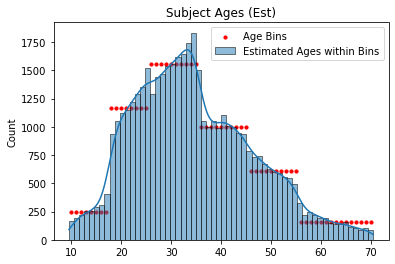

In [77]:
from estimate_ages import estimate_age_from_categorical


df['Subject Age (Est)'] = estimate_age_from_categorical(df, UNKNOWN)

In [55]:
# Engineer new features

# Calculate Officer Age
if 'Officer YOB' in df.columns:
    df['Officer Age'] = df['Reported Date'].apply(lambda x: x.year) - df['Officer YOB']
    median_yob = int(df['Officer YOB'].median())
    df['Officer Age'] = df['Officer Age'].apply(lambda x: median_yob if x > 100 else x)
    df.drop('Officer YOB', axis=1, inplace=True)

    
# Determine whether or not weapon was involved
#has_weapon = lambda x: 'No' if x == 'None' else 'Yes'
df['Weapon (Y/N)'] = (df['Weapon Type'] != 'None').astype('int')


# Calculate the number of stops per subject
if 'Subject ID' in df.columns:
    offense_ct_dict = dict(df['Subject ID'].value_counts())
    df['Offense Count'] = df['Subject ID'].map(offense_ct_dict)
    # Identify whether a subject has been involved in multiple stops
    df['Repeat Offender (Y/N)'] = (df['Offense Count'] > 1).astype('int')
    # Drop "Offense Count" for now given the number of missing values
    if 'Offense Count' in df:
        df.drop('Offense Count', axis=1, inplace=True)
    df.drop('Subject ID', axis=1, inplace=True)


# Identify whether race of officer is same as race of subject
df['Same Race (Y/N)'] = (df['Officer Race'] == df['Subject Perceived Race']).astype('int')

# Identify whether gender of officer is same as gender of subject
df['Same Gender (Y/N)'] = (df['Officer Gender'] == df['Subject Perceived Gender']).astype('int')

# Rename columns and drop 'na' rows
if 'Arrest Flag' in df.columns:
    df['Arrest (Y/N)'] = (df['Arrest Flag'] == 'Y').astype('int')
    df.drop('Arrest Flag', axis=1, inplace=True)
    
if 'Frisk Flag' in df.columns:
    df['Frisk (Y/N)'] = (df['Frisk Flag'] == 'Y').astype('int')
    df.drop('Frisk Flag', axis=1, inplace=True)
    
# Stop resolution
df['Stop Resolution: Arrest (Method2)'] = (df['Stop Resolution'] == 'Arrest').astype('int')


# Revisiting subject perceived gender
# Difficult decision to make, but with a sample size of only 5 people, the 
# amount of data is insufficient to provide a statistically significant understanding
# of how non-binary perception affects arrest rate
df['Subject Perceived Gender'].replace('Non-Binary', UNKNOWN, inplace=True)
df['Officer Gender'].replace('Non-Binary', UNKNOWN, inplace=True)

# Optionally categorize 'Officer Squad'
# Officer Squad

In [56]:
# Remove missing values and reset index
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

### Determine which "Arrest" field to use:
- Option 1: 'Arrest Flag', which is now renamed to 'Arrest (Y/N)'
- Option 2: 'Stop Resolution' value of 'Arrest'

In [57]:
print('Option 1:')
print(df['Arrest (Y/N)'].value_counts())
print('\nOption 2:')
print(df['Stop Resolution: Arrest (Method2)'].value_counts())

Option 1:
0    41830
1     3439
Name: Arrest (Y/N), dtype: int64

Option 2:
0    33902
1    11367
Name: Stop Resolution: Arrest (Method2), dtype: int64


##### Since there are more in Option 2, determine if all positives from Option 1 are included in this subset

In [58]:
# Determine if all of
method2 = df.loc[df['Stop Resolution: Arrest (Method2)']==1].copy()
method2['Arrest (Y/N)'].value_counts()

0    7930
1    3437
Name: Arrest (Y/N), dtype: int64

##### All but 2 of the positive Arrest (Y/N) values are included in 'Stop Resolution: Arrest'. As a result, we see that the former is a subset of the latter. It is unclear why, but for the scope of this analysis, we will use the latter for the sake of a larger scope. 

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45269 entries, 0 to 45268
Data columns (total 28 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Subject Age Group                  45269 non-null  object        
 1   GO / SC Num                        45269 non-null  object        
 2   Terry Stop ID                      45269 non-null  object        
 3   Stop Resolution                    45269 non-null  object        
 4   Weapon Type                        45269 non-null  object        
 5   Officer ID                         45269 non-null  object        
 6   Officer Gender                     45269 non-null  object        
 7   Officer Race                       45269 non-null  object        
 8   Subject Perceived Race             45269 non-null  object        
 9   Subject Perceived Gender           45269 non-null  object        
 10  Reported Date                     

In [60]:
df.rename({'Stop Resolution: Arrest (Method2)':'Stop Resolution: Arrest (Y/N)'}, axis=1, inplace=True)
df.drop('Arrest (Y/N)', axis=1, inplace=True)

## Expand scope of target metric

In [61]:
categorize_resolution = {
    'Field Contact': 'Neutral',
    'Offense Report': 'Negative',
    'Arrest': 'Negative',
    'Referred for Prosecution': 'Negative',
    'Citation / Infraction': 'Negative'
}


df['Resolution: Negative (Y/N)'] = (df['Stop Resolution'].map(categorize_resolution) == 'Negative').astype('int')
df.drop('Stop Resolution: Arrest (Y/N)', axis=1, inplace=True)

# Graphical EDA

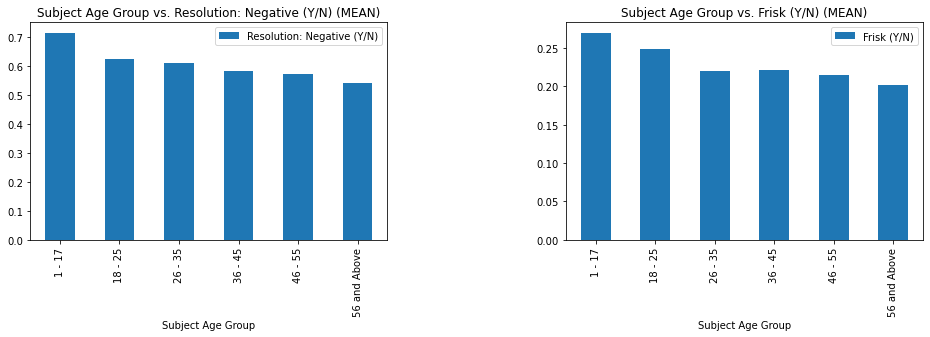

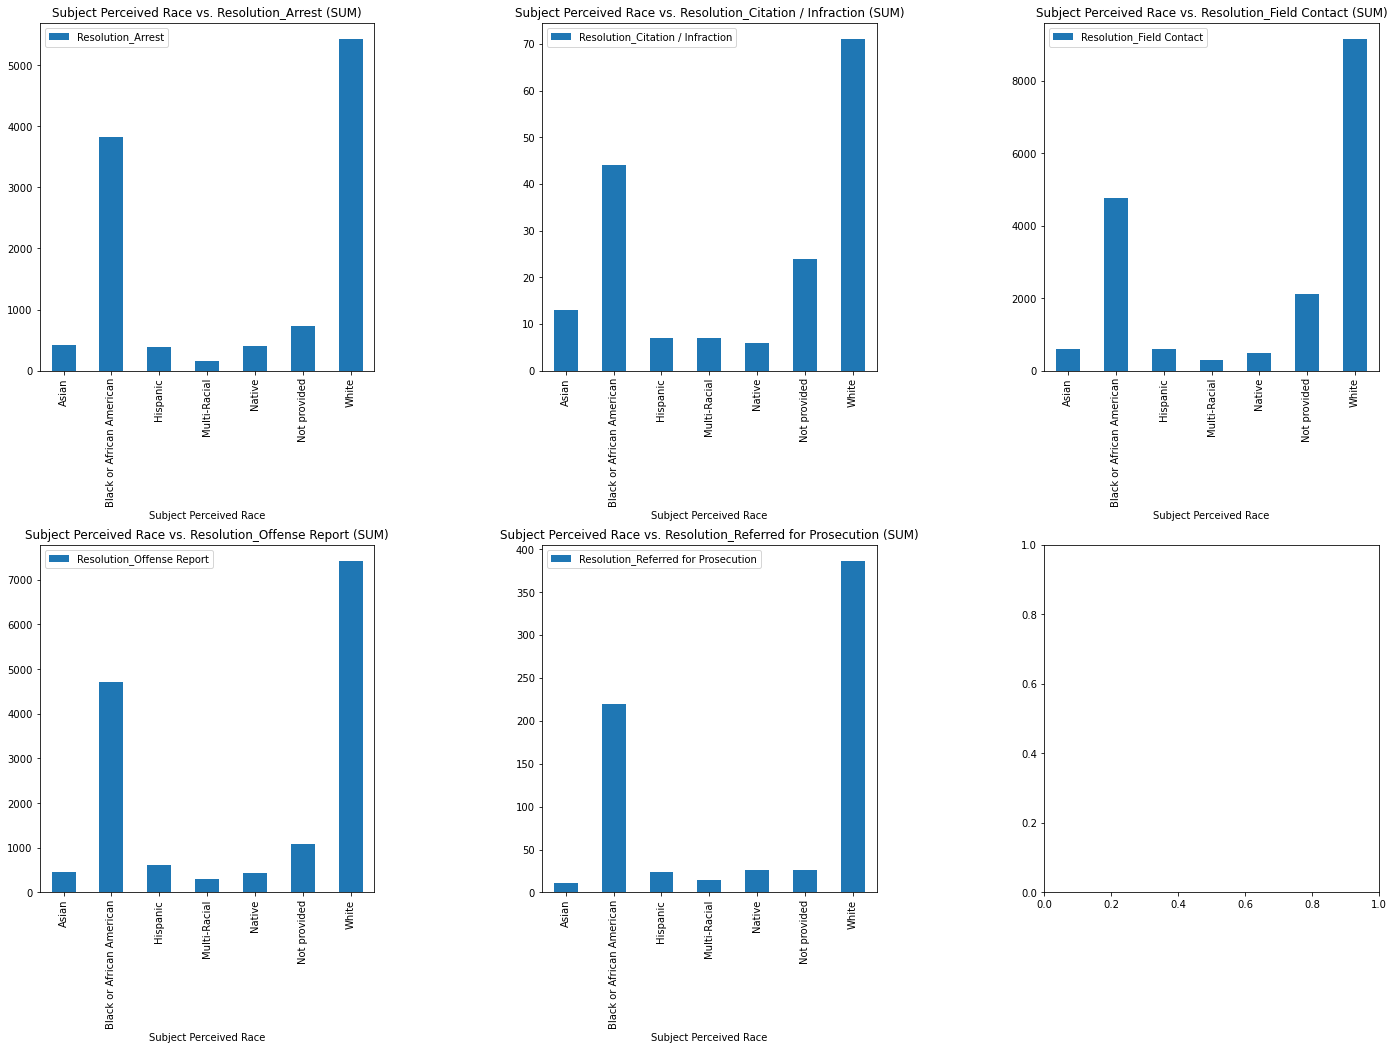

      Subject Perceived Race  Resolution_Arrest  \
6                      White             5427.0   
1  Black or African American             3830.0   
5               Not provided              732.0   
0                      Asian              424.0   
4                     Native              404.0   
2                   Hispanic              392.0   
3               Multi-Racial              158.0   

   Resolution_Citation / Infraction  Resolution_Field Contact  \
6                              71.0                    9145.0   
1                              44.0                    4756.0   
5                              24.0                    2112.0   
0                              13.0                     586.0   
4                               6.0                     497.0   
2                               7.0                     596.0   
3                               7.0                     298.0   

   Resolution_Offense Report  Resolution_Referred for Prosecution  
6 

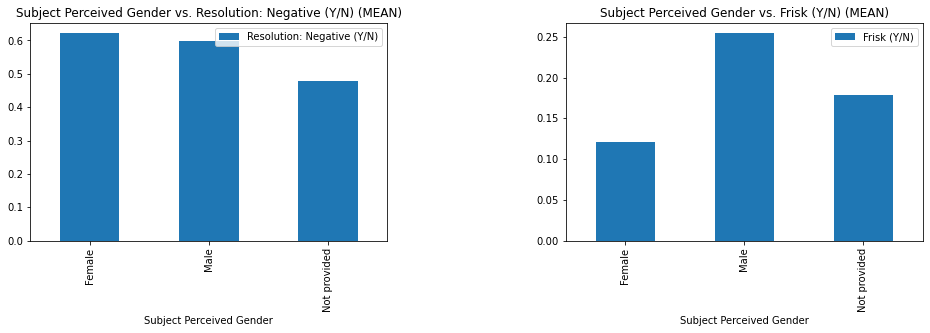

  Subject Perceived Gender  Resolution: Negative (Y/N)  Frisk (Y/N)
0                   Female                    0.620983     0.120444
1                     Male                    0.598327     0.254135
2             Not provided                    0.478571     0.178571
--------------------------------------------------------------------




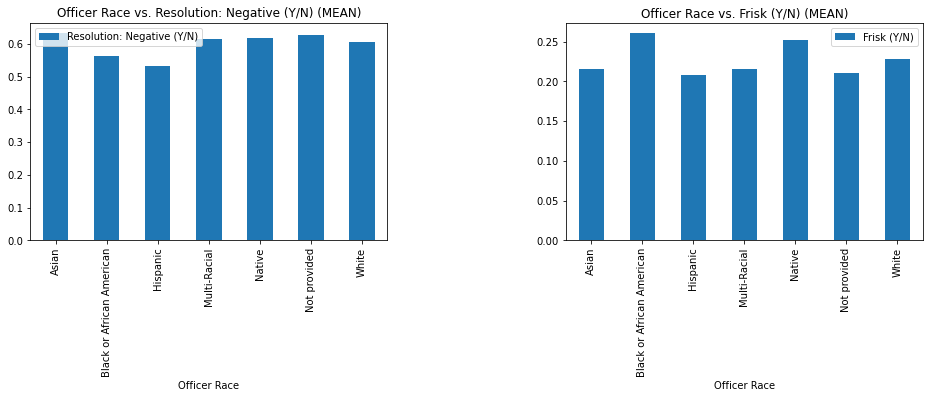

                Officer Race  Resolution: Negative (Y/N)  Frisk (Y/N)
0                      Asian                    0.631963     0.215513
5               Not provided                    0.628070     0.210526
4                     Native                    0.618331     0.251710
3               Multi-Racial                    0.613380     0.215869
6                      White                    0.605941     0.227713
1  Black or African American                    0.563953     0.260465
2                   Hispanic                    0.533282     0.208542
--------------------------------------------------------------------




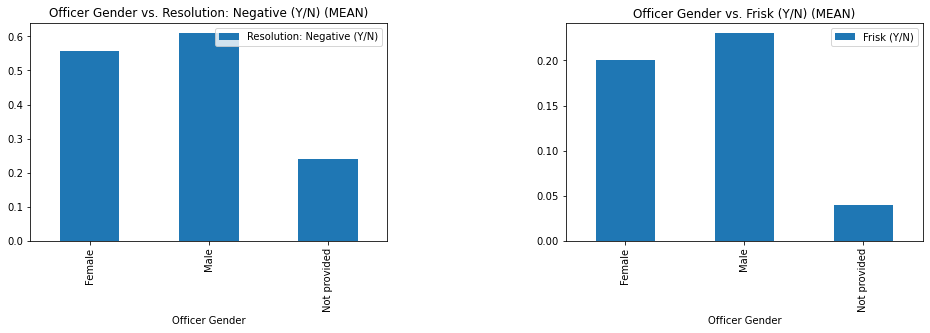

  Officer Gender  Resolution: Negative (Y/N)  Frisk (Y/N)
1           Male                    0.608861     0.230016
0         Female                    0.556364     0.200574
2   Not provided                    0.240000     0.040000
--------------------------------------------------------------------




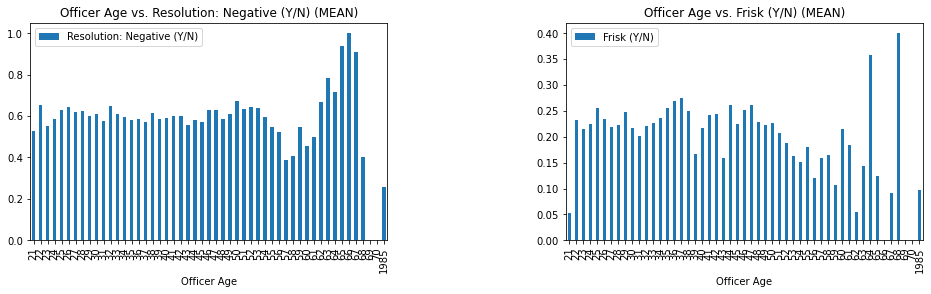

    Officer Age  Resolution: Negative (Y/N)  Frisk (Y/N)
45           66                    1.000000     0.000000
44           65                    0.937500     0.125000
46           67                    0.909091     0.090909
42           63                    0.785714     0.142857
43           64                    0.714286     0.357143
29           50                    0.673664     0.227099
41           62                    0.666667     0.055556
1            22                    0.652893     0.231405
11           32                    0.649759     0.221399
31           52                    0.643750     0.187500
5            26                    0.642273     0.234091
32           53                    0.640103     0.161954
30           51                    0.636145     0.207229
26           47                    0.631399     0.261092
25           46                    0.628866     0.251841
4            25                    0.628800     0.255467
7            28                

In [63]:
# BAR GRAPHS FOR ***AVERAGE OR SUM*** OF METRICS

df_graphical = pd.concat([df, pd.get_dummies(df['Stop Resolution'], prefix='Resolution')], axis=1)

# Average metrics by age group
x_axis = 'Subject Age Group'
y_axis = ['Resolution: Negative (Y/N)', 'Frisk (Y/N)']#, 'Resolution_Arrest', 'Resolution_Citation / Infraction', 'Resolution_Field Contact', 'Resolution_Offense Report', 'Resolution_Referred for Prosecution']
bar_plot(df_graphical, x_axis, y_axis, 'mean', verbose=False)

# Average metrics by subject race
x_axis = 'Subject Perceived Race'
y_axis = ['Resolution_Arrest', 'Resolution_Citation / Infraction', 'Resolution_Field Contact', 'Resolution_Offense Report', 'Resolution_Referred for Prosecution']
bar_plot(df_graphical, x_axis, y_axis, 'sum', verbose=True)

# Gender metrics
x_axis = 'Subject Perceived Gender'
y_axis = ['Resolution: Negative (Y/N)', 'Frisk (Y/N)']
bar_plot(df_graphical, x_axis, y_axis, 'mean', verbose=True)

# Officer race
x_axis = 'Officer Race'
bar_plot(df_graphical, x_axis, y_axis, 'mean',verbose=True)

# Officer gender
x_axis = 'Officer Gender'
bar_plot(df_graphical, x_axis, y_axis, 'mean', verbose=True)

# Officer age
x_axis = 'Officer Age'
bar_plot(df_graphical, x_axis, y_axis, 'mean', verbose=True)

# Refine dataset

In [13]:
# Refine dataset to continuous and categoricals w/reasonable number of unique values

# Separate columns by type
obj_columns = df.select_dtypes('object').columns
continuous_columns = df.drop(obj_columns, axis=1).columns

# Determine which columns are most valuable to OHE
# based on small enough number of values
cols_to_ohe = []
for col in obj_columns:
    if len(df[col].value_counts().index) < 30:
        cols_to_ohe.append(col)
    else:
        print('Excluding:', col)

df_refined = pd.concat([df[continuous_columns], df[cols_to_ohe]], axis=1)

print(f'Including: {df_refined.columns}')
#df_refined.info()

Excluding: GO / SC Num
Excluding: Terry Stop ID
Excluding: Officer ID
Excluding: Reported Time
Excluding: Initial Call Type
Excluding: Final Call Type
Excluding: Officer Squad
Excluding: Beat
Including: Index(['Reported Date', 'Subject Age (Est)', 'Officer Age', 'Weapon (Y/N)',
       'Repeat Offender (Y/N)', 'Same Race (Y/N)', 'Same Gender (Y/N)',
       'Frisk (Y/N)', 'Resolution: Negative (Y/N)', 'Subject Age Group',
       'Stop Resolution', 'Weapon Type', 'Officer Gender', 'Officer Race',
       'Subject Perceived Race', 'Subject Perceived Gender', 'Call Type',
       'Precinct', 'Sector'],
      dtype='object')


##### Plot distributions

In [14]:
# #nrows = int(np.ceil(len(continuous_columns)/4))
# nrows = int(np.ceil(df_refined.shape[1]/4))
# fig, axes = plt.subplots(ncols=4, nrows=nrows, figsize=(22, 4*nrows))

# for ax, col in zip(axes.flatten(), df_refined.columns):
#     ax.hist(df_refined[col])
#     ax.set_title(col)
#     ax.tick_params('x', labelrotation=45)
#     #ax.tick_params(labelrotation=45)
    
# plt.subplots_adjust(wspace=.75, hspace=.75)

# Begin Modeling

Which features have a connection with y?

In [15]:
df_refined.loc[df_refined['Resolution: Negative (Y/N)']==1]['Stop Resolution'].value_counts()

Offense Report              15032
Arrest                      11367
Referred for Prosecution      708
Citation / Infraction         172
Name: Stop Resolution, dtype: int64

In [16]:
col = df_refined.columns[0]

df_refined.corr()

,Subject Age (Est),Officer Age,Weapon (Y/N),Repeat Offender (Y/N),Same Race (Y/N),Same Gender (Y/N),Frisk (Y/N),Resolution: Negative (Y/N)
Subject Age (Est),1.000000,0.005113,0.017549,-0.059363,0.041795,0.045624,-0.031516,-0.060528
Officer Age,0.005113,1.000000,-0.001571,-0.009316,-0.000076,-0.029454,-0.011163,-0.021069
Weapon (Y/N),0.017549,-0.001571,1.000000,-0.010797,0.022367,0.070006,0.376407,0.079710
Repeat Offender (Y/N),-0.059363,-0.009316,-0.010797,1.000000,0.055296,0.010693,-0.040161,0.103345
Same Race (Y/N),0.041795,-0.000076,0.022367,0.055296,1.000000,-0.013593,-0.054436,-0.016360
Same Gender (Y/N),0.045624,-0.029454,0.070006,0.010693,-0.013593,1.000000,0.110849,0.006146
Frisk (Y/N),-0.031516,-0.011163,0.376407,-0.040161,-0.054436,0.110849,1.000000,0.144831
Resolution: Negative (Y/N),-0.060528,-0.021069,0.079710,0.103345,-0.016360,0.006146,0.144831,1.000000


In [17]:
df_refined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45269 entries, 0 to 45268
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Reported Date               45269 non-null  datetime64[ns]
 1   Subject Age (Est)           45269 non-null  float64       
 2   Officer Age                 45269 non-null  int64         
 3   Weapon (Y/N)                45269 non-null  int32         
 4   Repeat Offender (Y/N)       45269 non-null  int32         
 5   Same Race (Y/N)             45269 non-null  int32         
 6   Same Gender (Y/N)           45269 non-null  int32         
 7   Frisk (Y/N)                 45269 non-null  int32         
 8   Resolution: Negative (Y/N)  45269 non-null  int32         
 9   Subject Age Group           45269 non-null  object        
 10  Stop Resolution             45269 non-null  object        
 11  Weapon Type                 45269 non-null  object    

In [18]:
# Split data
y_label = 'Resolution: Negative (Y/N)'
X = df_refined.drop([y_label,
                     'Frisk (Y/N)', 
                     'Reported Date', 
                     'Subject Age Group', 
                     'Stop Resolution'], 
                     axis=1)
y = df_refined[y_label]

X, X_test, y, y_test = train_test_split(X, y, random_state = RANDOM_STATE)

# Remove temptation to touch test dataset
test_data = {'X_test': X_test, 'y_test': y_test}
with open (os.path.join(processed_data_path, 'test_data.pickle'), 'wb') as f:
    pickle.dump (test_data, f)
X_test = None
y_test = None
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

# Declare object to hold history of all model runs
model_history = ModelHistory()
final_models = []

In [19]:
# One hot encoder
droppers = [UNKNOWN]*X.select_dtypes('object').shape[1]
one_hot_encoder = OneHotEncoder(sparse=False, drop=droppers, handle_unknown='error')

# Selectors
string_selector = make_column_selector(dtype_include='object')
number_selector = make_column_selector(dtype_include='number')


# Column transformers
transformer_basic = make_column_transformer((one_hot_encoder, string_selector), n_jobs=JOBS)

transformer_ss = make_column_transformer((one_hot_encoder, string_selector), 
                                          (StandardScaler(), number_selector), n_jobs=JOBS)

transformer_minmax = make_column_transformer((one_hot_encoder, string_selector), 
                                             (MinMaxScaler(), number_selector), n_jobs=JOBS)


# K-Fold cross validation
kfold = KFold(N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

# Resampling (smote)
smote = SMOTE(random_state = RANDOM_STATE, n_jobs=JOBS)

# Models
model_logreg = LogisticRegression(random_state=RANDOM_STATE, max_iter=10000, n_jobs=JOBS)
model_knn = KNeighborsClassifier(n_jobs=JOBS)
model_dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
model_rf = RandomForestClassifier(random_state=RANDOM_STATE)
model_xgb = XGBClassifier(use_label_encoder=False, eval_metric = 'logloss', random_state=RANDOM_STATE, n_jobs=JOBS)

### Logistic Regression

In [20]:
# # --- BASELINE (CONTINUOUS) ---
X_numeric = X.select_dtypes(exclude='object')
model_logreg.fit(X_numeric, y)
model_history.add_model(model_logreg, X_numeric, y, notes='Logreg baseline - DROPPING UNKNOWNS THIS ITERATION')

# # --- ADD CATEGORICALS ---
pipe = Pipeline([('cols', transformer_basic),
                 ('model', model_logreg)])
pipe.fit(X, y)
model_history.add_model(pipe, X, y, notes='logreg, add categoricals')


# # --- ADD SMOTE ---
pipe = Pipeline([('cols', transformer_basic),
                 ('smote', smote),
                 ('model', model_logreg)])
pipe.fit(X, y)
model_history.add_model(pipe, X, y, notes='logreg, add SMOTE')


# # --- ADD STANDARD SCALER ---
pipe = Pipeline([('cols', transformer_ss),
                 ('smote', smote),
                 ('model', model_logreg)])
pipe.fit(X, y)
model_history.add_model(pipe, X, y, notes='logreg, add standard scaler')


# # --- SWITCH TO MIN-MAX SCALER ---
pipe = Pipeline([('cols', transformer_minmax),
                 ('smote', smote),
                 ('model', model_logreg)])
pipe.fit(X, y)
model_history.add_model(pipe, X, y, notes='logreg, switch to min-max scaler')


# # --- ADD GRID SEARCH AND CROSS VAL ---
pipe = Pipeline([('cols', transformer_ss),
                 ('model', model_logreg)])
param_grid = {'model__C': np.logspace(-1, 4, 10)}
search = GridSearchCV(pipe, param_grid, cv=kfold, n_jobs=JOBS, scoring='f1', return_train_score=True)
search.fit(X, y);
model_history.add_model(search.best_estimator_, X, y, display_results=True, notes='logreg, grid search, cross val, no smote')

final_model_logreg = search.best_estimator_
final_models.append(final_model_logreg)

,Model,n_features,Features,F1 Score,Accuracy,Notes
0,"LogisticRegression(max_iter=10000, n_jobs=2, r...",6,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.737166,0.609879,Logreg baseline - DROPPING UNKNOWNS THIS ITERA...
1,"Pipeline(steps=[('cols',\n Col...",14,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.834661,0.785426,"logreg, add categoricals"
2,"Pipeline(steps=[('cols',\n Col...",14,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.818856,0.779182,"logreg, add SMOTE"
3,"Pipeline(steps=[('cols',\n Col...",14,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.825268,0.793143,"logreg, add standard scaler"
4,"Pipeline(steps=[('cols',\n Col...",14,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.825627,0.793732,"logreg, switch to min-max scaler"
5,"Pipeline(steps=[('cols',\n Col...",14,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.843157,0.797944,"logreg, grid search, cross val, no smote"


Train: 0.8426873364760897
Test: 0.8411333623666011


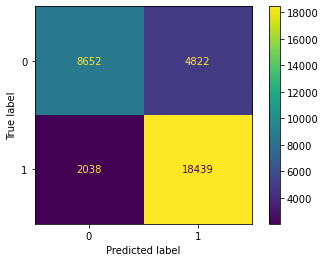

In [21]:
train_test_scores(search)
plot_confusion_matrix(final_model_logreg, X, y);

### K-Nearest Neighbors

In [22]:
pipe = Pipeline([('cols', transformer_ss),
                 ('model', model_knn)])

param_grid = {'model__leaf_size': [50],
               'model__n_neighbors': [3, 5, 7, 9]} 
search = GridSearchCV(pipe, param_grid, cv=kfold, n_jobs=JOBS, scoring='f1', return_train_score=True)
search.fit(X, y)
model_history.add_model(search.best_estimator_, X, y, display_results=True, notes='grid search KNN')

final_model_knn = search.best_estimator_
final_models.append(final_model_knn)

,Model,n_features,Features,F1 Score,Accuracy,Notes
0,"LogisticRegression(max_iter=10000, n_jobs=2, r...",6,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.737166,0.609879,Logreg baseline - DROPPING UNKNOWNS THIS ITERA...
1,"Pipeline(steps=[('cols',\n Col...",14,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.834661,0.785426,"logreg, add categoricals"
2,"Pipeline(steps=[('cols',\n Col...",14,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.818856,0.779182,"logreg, add SMOTE"
3,"Pipeline(steps=[('cols',\n Col...",14,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.825268,0.793143,"logreg, add standard scaler"
4,"Pipeline(steps=[('cols',\n Col...",14,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.825627,0.793732,"logreg, switch to min-max scaler"
5,"Pipeline(steps=[('cols',\n Col...",14,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.843157,0.797944,"logreg, grid search, cross val, no smote"
6,"Pipeline(steps=[('cols',\n Col...",14,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.860957,0.825749,grid search KNN


Train: 0.8733066633740921
Test: 0.8209901506588527


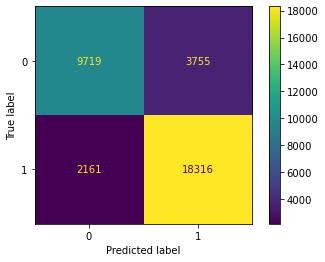

In [23]:
train_test_scores(search)
plot_confusion_matrix(final_model_knn, X, y);

### Decision Tree

In [24]:
pipe = Pipeline([('cols', transformer_ss),
                 ('model', model_dt)])

param_grid = {'model__max_depth': [3, 5, 7], 
              'model__criterion': ['gini', 'entropy'],
              'model__min_samples_split': [5, 10],
              'model__min_samples_leaf': [5, 10]} 

search = GridSearchCV(pipe, param_grid, cv=kfold, n_jobs=JOBS, scoring='f1', return_train_score=True)
search.fit(X, y)
model_history.add_model(search.best_estimator_, X, y, display_results=True, notes='grid-based decision tree')

final_model_dt = search.best_estimator_
final_models.append(final_model_dt)

,Model,n_features,Features,F1 Score,Accuracy,Notes
0,"LogisticRegression(max_iter=10000, n_jobs=2, r...",6,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.737166,0.609879,Logreg baseline - DROPPING UNKNOWNS THIS ITERA...
1,"Pipeline(steps=[('cols',\n Col...",14,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.834661,0.785426,"logreg, add categoricals"
2,"Pipeline(steps=[('cols',\n Col...",14,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.818856,0.779182,"logreg, add SMOTE"
3,"Pipeline(steps=[('cols',\n Col...",14,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.825268,0.793143,"logreg, add standard scaler"
4,"Pipeline(steps=[('cols',\n Col...",14,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.825627,0.793732,"logreg, switch to min-max scaler"
5,"Pipeline(steps=[('cols',\n Col...",14,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.843157,0.797944,"logreg, grid search, cross val, no smote"
6,"Pipeline(steps=[('cols',\n Col...",14,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.860957,0.825749,grid search KNN
7,"Pipeline(steps=[('cols',\n Col...",14,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.848290,0.806456,grid-based decision tree


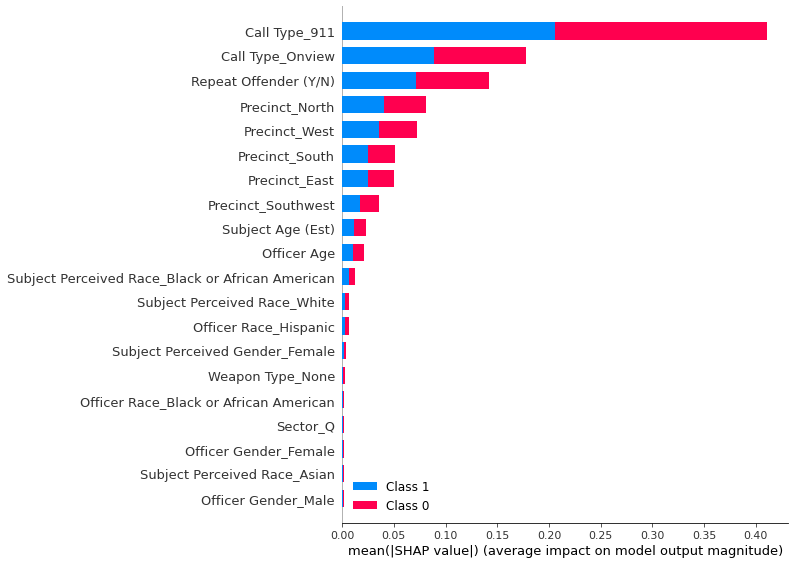

In [25]:
produce_shap_plot(X, y, one_hot_encoder, final_model_dt)

Train: 0.8403646710254976
Test: 0.8343124534313787


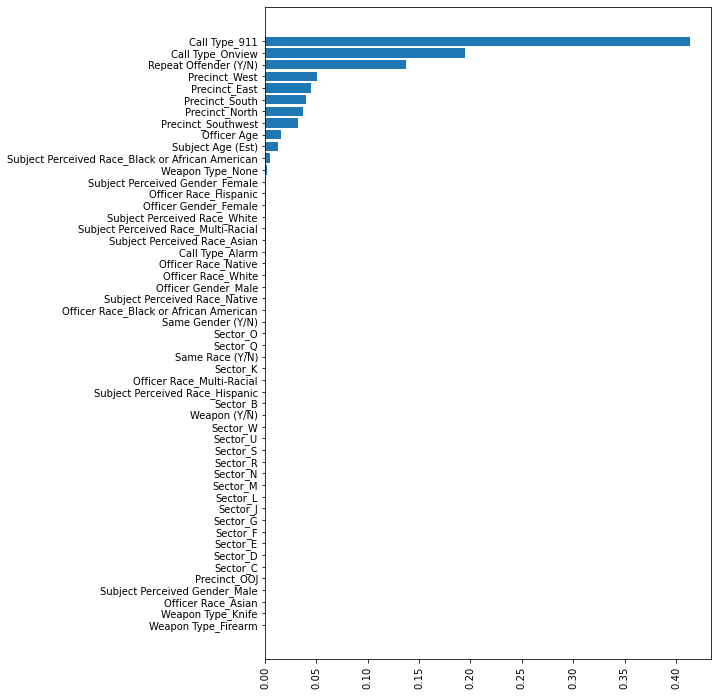

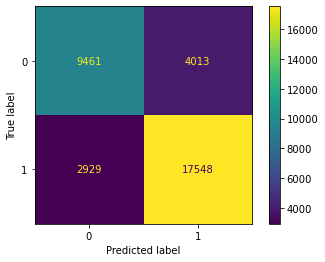

In [26]:
train_test_scores(search)
plot_importances(search, X)
plot_confusion_matrix(final_model_dt, X, y);

### Random Forest

In [27]:
param_grid = {
    'model__n_estimators': [25, 75, 150],
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [3, 6, 10],
    'model__min_samples_split': [5, 10],
    'model__min_samples_leaf': [3, 6]}


pipe = Pipeline([('cols', transformer_ss),
                 ('model', model_rf)])
search = GridSearchCV(pipe, param_grid, cv=kfold, n_jobs=JOBS, scoring='f1', return_train_score=True)
search.fit(X, y)
model_history.add_model(search.best_estimator_, X, y, display_results=True, notes='grid-based RF')

final_model_rf = search.best_estimator_
final_models.append(final_model_rf)

,Model,n_features,Features,F1 Score,Accuracy,Notes
0,"LogisticRegression(max_iter=10000, n_jobs=2, r...",6,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.737166,0.609879,Logreg baseline - DROPPING UNKNOWNS THIS ITERA...
1,"Pipeline(steps=[('cols',\n Col...",14,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.834661,0.785426,"logreg, add categoricals"
2,"Pipeline(steps=[('cols',\n Col...",14,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.818856,0.779182,"logreg, add SMOTE"
3,"Pipeline(steps=[('cols',\n Col...",14,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.825268,0.793143,"logreg, add standard scaler"
4,"Pipeline(steps=[('cols',\n Col...",14,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.825627,0.793732,"logreg, switch to min-max scaler"
5,"Pipeline(steps=[('cols',\n Col...",14,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.843157,0.797944,"logreg, grid search, cross val, no smote"
6,"Pipeline(steps=[('cols',\n Col...",14,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.860957,0.825749,grid search KNN
7,"Pipeline(steps=[('cols',\n Col...",14,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.848290,0.806456,grid-based decision tree
8,"Pipeline(steps=[('cols',\n Col...",14,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.859943,0.813113,grid-based RF


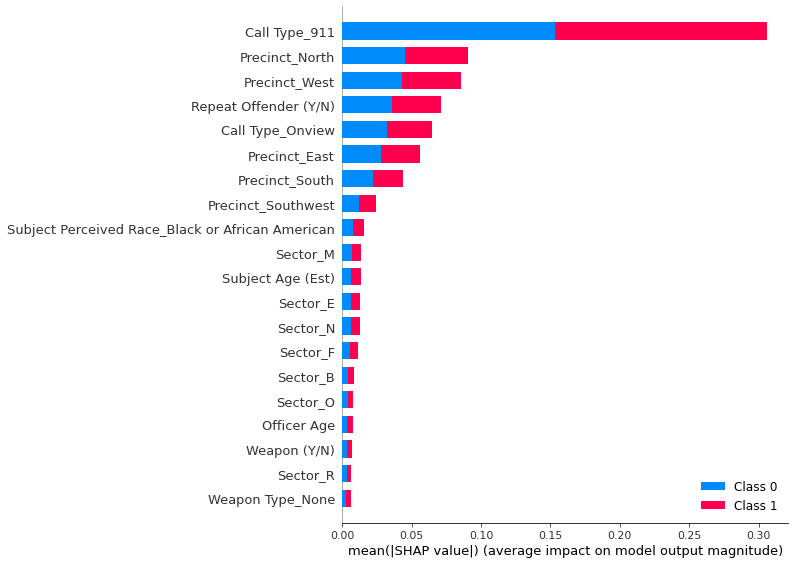

In [28]:
produce_shap_plot(X, y, one_hot_encoder, final_model_rf)

Train: 0.8502962157981764
Test: 0.8449516309060334


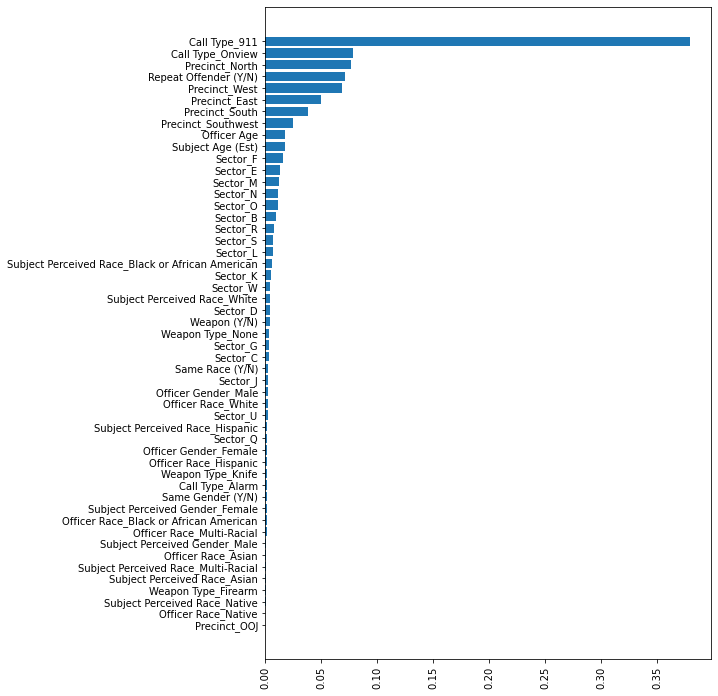

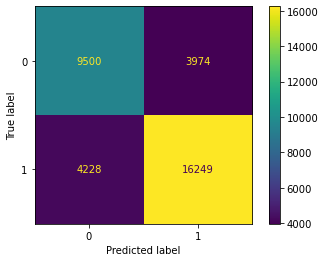

In [29]:
train_test_scores(search)
plot_importances(search, X)
plot_confusion_matrix(final_model_rf, X, y);

### XG Boost

In [43]:
param_grid = {
    'model__learning_rate': [0.1, 0.2],
    'model__max_depth': [3, 6],
    'model__min_child_weight': [1, 2],
    'model__subsample': [0.5, 0.7],
    'model__n_estimators': [100, 150]}

pipe = Pipeline([('cols', transformer_ss),
                 ('model', model_xgb)])

search = GridSearchCV(pipe, param_grid, cv=kfold, n_jobs=JOBS, scoring='f1', return_train_score=True)
search.fit(X, y)
model_history.add_model(search.best_estimator_, X, y, display_results=True, notes='grid-based xgb')

final_model_xgb = search.best_estimator_

final_models.append(final_model_xgb)

,Model,n_features,Features,F1 Score,Accuracy,Notes
0,"LogisticRegression(max_iter=10000, n_jobs=2, r...",6,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.737166,0.609879,Logreg baseline - DROPPING UNKNOWNS THIS ITERA...
1,"Pipeline(steps=[('cols',\n Col...",14,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.834661,0.785426,"logreg, add categoricals"
2,"Pipeline(steps=[('cols',\n Col...",14,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.818856,0.779182,"logreg, add SMOTE"
3,"Pipeline(steps=[('cols',\n Col...",14,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.825268,0.793143,"logreg, add standard scaler"
4,"Pipeline(steps=[('cols',\n Col...",14,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.825627,0.793732,"logreg, switch to min-max scaler"
5,"Pipeline(steps=[('cols',\n Col...",14,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.843157,0.797944,"logreg, grid search, cross val, no smote"
6,"Pipeline(steps=[('cols',\n Col...",14,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.860957,0.825749,grid search KNN
7,"Pipeline(steps=[('cols',\n Col...",14,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.848290,0.806456,grid-based decision tree
8,"Pipeline(steps=[('cols',\n Col...",14,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.859943,0.813113,grid-based RF
9,"Pipeline(steps=[('cols',\n Col...",14,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.870754,0.836028,grid-based xgb


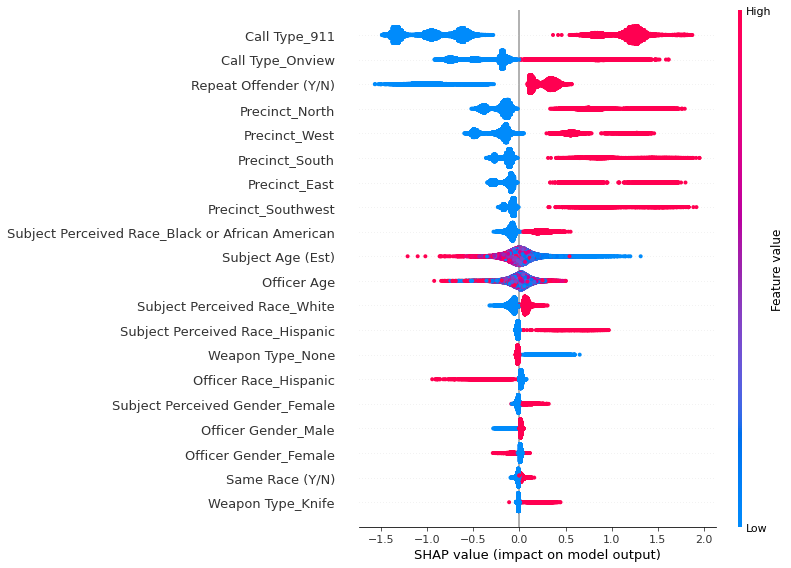

In [48]:
produce_shap_plot(X, y, one_hot_encoder, final_model_xgb)

In [49]:
final_model_xgb[0]

ColumnTransformer(n_jobs=2,
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop=array(['Not provided', 'Not provided', 'Not provided', 'Not provided',
       'Not provided', 'Not provided', 'Not provided', 'Not provided'],
      dtype=object),
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001F483F7DDC0>),
                                ('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001F483F65340>)])

Train: 0.8686491212604283
Test: 0.8437047007493703


ValueError: feature_names mismatch: ['Weapon Type_Firearm', 'Weapon Type_Knife', 'Weapon Type_None', 'Officer Gender_Female', 'Officer Gender_Male', 'Officer Race_Asian', 'Officer Race_Black or African American', 'Officer Race_Hispanic', 'Officer Race_Multi-Racial', 'Officer Race_Native', 'Officer Race_White', 'Subject Perceived Race_Asian', 'Subject Perceived Race_Black or African American', 'Subject Perceived Race_Hispanic', 'Subject Perceived Race_Multi-Racial', 'Subject Perceived Race_Native', 'Subject Perceived Race_White', 'Subject Perceived Gender_Female', 'Subject Perceived Gender_Male', 'Call Type_911', 'Call Type_Alarm', 'Call Type_Onview', 'Precinct_East', 'Precinct_North', 'Precinct_OOJ', 'Precinct_South', 'Precinct_Southwest', 'Precinct_West', 'Sector_B', 'Sector_C', 'Sector_D', 'Sector_E', 'Sector_F', 'Sector_G', 'Sector_J', 'Sector_K', 'Sector_L', 'Sector_M', 'Sector_N', 'Sector_O', 'Sector_Q', 'Sector_R', 'Sector_S', 'Sector_U', 'Sector_W', 'Subject Age (Est)', 'Officer Age', 'Weapon (Y/N)', 'Repeat Offender (Y/N)', 'Same Race (Y/N)', 'Same Gender (Y/N)'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50']
expected Call Type_Alarm, Precinct_Southwest, Subject Perceived Race_Hispanic, Sector_E, Officer Race_Multi-Racial, Sector_R, Precinct_East, Call Type_Onview, Precinct_South, Sector_C, Officer Age, Sector_D, Weapon (Y/N), Precinct_North, Officer Gender_Male, Officer Race_Asian, Precinct_OOJ, Sector_N, Sector_O, Sector_J, Weapon Type_Firearm, Same Race (Y/N), Sector_G, Subject Perceived Race_Asian, Precinct_West, Call Type_911, Sector_B, Sector_F, Sector_M, Subject Perceived Gender_Male, Officer Gender_Female, Weapon Type_None, Subject Perceived Race_Black or African American, Subject Perceived Gender_Female, Officer Race_Black or African American, Officer Race_Hispanic, Sector_K, Officer Race_Native, Officer Race_White, Subject Perceived Race_Native, Sector_Q, Sector_S, Sector_L, Sector_W, Subject Perceived Race_White, Subject Age (Est), Repeat Offender (Y/N), Weapon Type_Knife, Subject Perceived Race_Multi-Racial, Sector_U, Same Gender (Y/N) in input data
training data did not have the following fields: f43, f30, f37, f1, f15, f35, f48, f2, f34, f9, f14, f38, f12, f49, f44, f41, f17, f21, f31, f32, f18, f33, f11, f19, f27, f7, f39, f42, f46, f16, f10, f50, f24, f13, f6, f26, f40, f22, f47, f5, f20, f3, f45, f25, f29, f0, f36, f23, f4, f28, f8

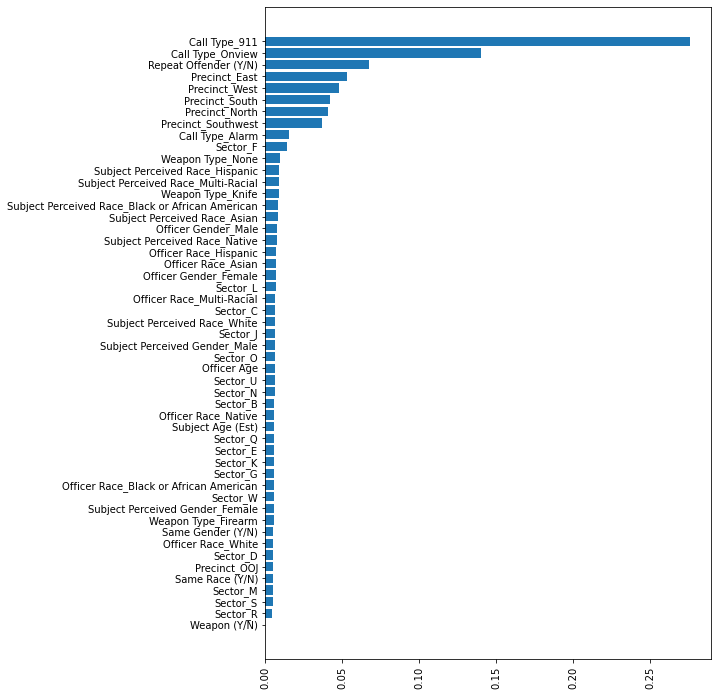

In [50]:
train_test_scores(search)
plot_importances(search, X)
plot_confusion_matrix(final_model_xgb, X, y);

### Based on cumulative results, define the best model:

In [ ]:
# CHANGE THIS CELL BASED ON FINAL RESULTS!!!

best_model = final_model_rf

# To do
FOR "REOEAT OFFENDER" MAKE SURE NOT TO CLASSIFY THEIR FIRST
OFFENSE AS A REPEAT

- **USE METRIC OF AGE GROUPS INSTEAD AND SEE HOW RESULTS COMPARE**


- Once a model is selected, how should the results be presented?
    - Back up any sort of conclusion with hypothesis testing
    - If it is a tree-based model, consider printing out the graphical representation of the tree that was used
    - Regarding how to gain meaning from results:
        - Perhaps use hypothesis testing to see extent of results
        - If linear model: bootstrapping can be used to get coefficients
        - If non-linear (non-parametric) models: once final model is selected, run it again without race (e.g.) to see how error changes. Also see how much the error changes when dropping other features?
    - Could also use step-forward (e.g.) feature selection function that was implemented in the lab project. Make sure to change from R2 eval metric to F1 (or whatever I end up using). Also make sure this is looking at the result on validation data, not just overall data (reduce overfitting). 
    
- Try running from scratch with different 'Arrest' flag metric
- Where input (e.g. Officer Age) is continuous: run hypothesis test. Alternatively, do bootstapping for categorical  



- INTERESTING THING TO CONSIDER: COULD YOU CREATE A LINEAR MODEL WITH JUST THESE 3 FEATURES (DT). CONSIDER VISUALIZING HOW AGE AFFECTS ARRESTS


## Finalizing the findings of the model:
- Back up with hypothesis testing
- If a tree-based model, consider printing out graphical representation of the tree that was used
- If linear model: use bootstrapping to get coefficients
- If non-linear (non-parametric) model: run the model twice, once with race (e.g.) and once without race to see how error changes. 

# Questions
- Why does F1 get worse for logreg once GridSearch is implemented?
- In cases of grid search, should I be just adding best_estimator_ to the model history to avoid re-running everything within the model history object?

##### For report "next steps" section:
- Feature to represent whether it is a repeat offense
- More formulaic feature selection process such as step-forward feature selection
- Create model for filling in missing ages instead of dropping values

# Selecting the Winning Model
After the above testing, it has become evident that the XXXXX model highest the highest predictive power. 

# Testing the Model on Fresh Data
Apply the withheld "Test" data to the best performing model

In [ ]:
with open (os.path.join(processed_data_path, 'test_data.pickle'), 'rb') as f:
    test_data = pickle.load(f)
    
X_test = test_data['X_test']
y_test = test_data['y_test']

f1 = f1_score(y_test, best_model.predict(X_test))

print(f'F1 score for top model: {f1}')
# for model in final_models:
#     f1 = f1_score(y_test, model.predict(X_test))
#     print('F1 Score for {} model: {}'.format(str(model[1])[:13].upper(), round(f1, 5)))

In [ ]:
plot_confusion_matrix(best_model, X_test, y_test);

[DISCUSS SIGNIFICANCE OF RELATIVE IMPORTANCES

In [ ]:
# Interpreting SHAP plots:
# https://blog.datascienceheroes.com/how-to-interpret-shap-values-in-r/

produce_shap_plot(X_test, y_test, one_hot_encoder, best_model, 
                  df_train_for_fitting_only=X, target_train_for_fitting_only=y)

In [ ]:
# CODE SOURCE: https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/decision_plot.html
#              https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/decision_plot.html
def legend_labels(idx):
    return [f'\${i * 100:,} ({hypothetical_predictions[i]:.2f})' for i in idx]

show_idx = [0, 30, 31, 50]
shap.decision_plot(expected_value, hypothetical_shap_values[show_idx], X, feature_order=feature_idx,
                   link='logit', legend_labels=legend_labels(show_idx), legend_location='upper center')

**Drop subject race and compare results**

In [ ]:
df_train_wo_subject_race, df_test_wo_subject_race = get_df(X_test, X_train, ohe)

model_wo_subject_race = best_model.copy().steps[1][1]
model_wo_subject_race.fit(df_train_wo_subject_race, y)

pred = model.predict(df_test_wo_subject_race)
f1 = f1_score(y_test, pred)
f1

In [ ]:
NEXT - CREATE SEPARATE DATAFRAMES: DROP ALL ROWS THAT AREN'T OF EACH SELECTED RACE, THEN RUN THE BEST MODEL. AFTER THAT, PLOT RESULTS ON THE SHAP DECISION PLOT!